In [1]:
# --- CHUNK 1: ENVIRONMENT & IMPORTS ---
import os
import sys
import json
import cv2
import gc
import random
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from pathlib import Path
from dataclasses import dataclass
import urllib.parse
import logging

# Install professional CV libraries + TorchMetrics for IoU
os.system('pip install -q segmentation-models-pytorch albumentations ultralytics torchmetrics')

# Import specific modules after installation
import segmentation_models_pytorch as smp
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
import torchmetrics

# Setup Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
LOGGER = logging.getLogger("TRAINER")
warnings.filterwarnings("ignore")

print("✅ Environment Ready. GPU: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Environment Ready. GPU:  Tesla P100-PCIE-16GB


In [2]:
# --- CHUNK 2: CONFIGURATION & SEEDING ---
@dataclass
class Config:
    # --- PATHS (Update these matches your specific Kaggle input structure) ---
    RAW_JSON: Path = Path("/kaggle/input/training-patch/Work/project-6-at-2025-12-05-19-05-697baf6e.json")
    RAW_IMG_DIR: Path = Path("/kaggle/input/training-patch/Work/InnerGize/Datasets/Device_Placement")
    WORK_DIR: Path = Path("/kaggle/working/prod_pipeline_v2")
    
    # --- MODEL ARCHITECTURE ---
    ARCH: str = 'UnetPlusPlus'
    ENCODER: str = 'resnet34'
    INPUT_SIZE: int = 512
    IN_CHANNELS: int = 1  # Grayscale (Critical for small datasets)
    
    # --- TRAINING HYPERPARAMETERS ---
    FOLDS: int = 10
    EPOCHS: int = 40      # Enough for convergence on small data
    BATCH_SIZE: int = 16   
    LR: float = 1e-4
    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED: int = 42

    def __post_init__(self):
        self.IMG_OUT = self.WORK_DIR / "images"
        self.MASK_OUT = self.WORK_DIR / "masks"
        self.MODEL_DIR = self.WORK_DIR / "models"
        
        # Create storage directories
        os.makedirs(self.IMG_OUT, exist_ok=True)
        os.makedirs(self.MASK_OUT, exist_ok=True)
        os.makedirs(self.MODEL_DIR, exist_ok=True)

CFG = Config()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.SEED)
print("✅ Configuration Loaded & Seeded.")

✅ Configuration Loaded & Seeded.


In [3]:
# --- CHUNK 3: PREPROCESSING ENGINE (FIXED FOR LABEL STUDIO JSON) ---
class Preprocessor:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.yolo = YOLO('yolo11n-seg.pt')

    def process_data(self):
        # Flatten existing file check
        existing = list(self.cfg.IMG_OUT.glob("*.png"))
        
        if len(existing) >= 250:
            LOGGER.info(f"Found {len(existing)} processed images. Skipping generation.")
            return sorted([f.name for f in self.cfg.IMG_OUT.iterdir()])

        LOGGER.info("Starting Smart Crop Pipeline...")
        with open(self.cfg.RAW_JSON, 'r') as f: 
            data = json.load(f)
        
        # FIX 1: Access 'data' -> 'image'
        valid_items = [x for x in data if x.get('data', {}).get('image')]
        
        count = 0
        for item in tqdm(valid_items, desc="Processing Images"):
            fname = "Unknown"
            try:
                # 1. URL Parsing (Corrected for your JSON)
                url = item['data']['image']
                if "?d=" in url: url = url.split("?d=")[1]
                clean_url = urllib.parse.unquote(url).replace("\\", "/")
                fname = Path(clean_url).name
                img_path = self.cfg.RAW_IMG_DIR / fname
                
                if not img_path.exists(): 
                    # print(f"File not found: {img_path}")
                    continue

                # 2. Load Image
                img_bgr = cv2.imread(str(img_path))
                if img_bgr is None: continue
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                h, w = img_rgb.shape[:2]

                # 3. YOLO Subject Isolation
                infer_img = cv2.resize(img_rgb, (640, 640))
                results = self.yolo(infer_img, verbose=False)
                
                person_mask = np.zeros((h, w), dtype=np.uint8)
                if results[0].masks:
                    idx = torch.argmax(results[0].boxes.xywh[:, 2] * results[0].boxes.xywh[:, 3])
                    m = results[0].masks.data[idx].cpu().numpy()
                    person_mask = (cv2.resize(m, (w, h)) > 0.5).astype(np.uint8)
                else:
                    cv2.rectangle(person_mask, (w//4, h//4), (3*w//4, 3*h//4), 1, -1)

                # 4. Background Removal & Grayscale
                isolated_rgb = np.where(np.stack((person_mask,) * 3, axis=-1) > 0, img_rgb, 0)
                gray_img = cv2.cvtColor(isolated_rgb, cv2.COLOR_RGB2GRAY)

                # 5. Process Ground Truth Label (FIX 2: Correct Label Studio Parsing)
                gt_mask = np.zeros((h, w), dtype=np.uint8)
                pts = []
                
                # Dig into annotations -> result -> value
                if item.get('annotations') and len(item['annotations']) > 0:
                    annotation = item['annotations'][0]
                    if annotation.get('result'):
                        for res in annotation['result']:
                            if res['type'] == 'polygonlabels':
                                val = res['value']
                                # Label Studio uses 0-100% coordinates
                                raw_points = np.array(val['points'])
                                
                                # Convert % to pixels using original image dims
                                # Note: Use result's original_width/height if available, else current h/w
                                ow = res.get('original_width', w)
                                oh = res.get('original_height', h)
                                
                                pixel_points = (raw_points * [ow/100, oh/100]).astype(np.int32)
                                pts = pixel_points # Save for crop calculation
                                cv2.fillPoly(gt_mask, [pts], 1)
                                break # Assuming 1 patch per image

                # 6. Smart Crop Math
                y_head = np.argmax(np.any(person_mask, axis=1)) if np.any(person_mask) else 0
                
                # If we found label points, use them for crop height. If not, fallback to full image.
                if len(pts) > 0:
                    y_device = int(np.max(pts[:, 1]))
                else:
                    y_device = h

                roi_h = max(y_device - y_head, h // 3)
                dim = max(int(roi_h * 1.8), 300)
                
                center_x = int(np.dot(np.arange(w), np.sum(person_mask, axis=0)) / (np.sum(person_mask)+1e-6))
                
                half = dim // 2
                x1, y1 = center_x - half, y_head + (roi_h // 2) - half
                p_l, p_t = max(0, -x1), max(0, -y1)
                p_r, p_b = max(0, (x1 + dim) - w), max(0, (y1 + dim) - h)
                
                padded_gray = cv2.copyMakeBorder(gray_img, p_t, p_b, p_l, p_r, cv2.BORDER_CONSTANT, value=0)
                padded_mask = cv2.copyMakeBorder(gt_mask, p_t, p_b, p_l, p_r, cv2.BORDER_CONSTANT, value=0)
                
                cx, cy = x1 + p_l, y1 + p_t
                fin_img = cv2.resize(padded_gray[cy:cy+dim, cx:cx+dim], (self.cfg.INPUT_SIZE, self.cfg.INPUT_SIZE))
                fin_mask = cv2.resize(padded_mask[cy:cy+dim, cx:cx+dim], (self.cfg.INPUT_SIZE, self.cfg.INPUT_SIZE), interpolation=cv2.INTER_NEAREST)

                # 7. Save
                out_name = Path(fname).stem + ".png"
                cv2.imwrite(str(self.cfg.IMG_OUT / out_name), fin_img)
                cv2.imwrite(str(self.cfg.MASK_OUT / out_name), fin_mask * 255)
                count += 1
                
            except Exception as e:
                print(f"❌ Failed on {fname}: {e}")
                continue
                
        LOGGER.info(f"✅ Preprocessing complete. Saved {count} standardized samples.")
        return sorted([f.name for f in self.cfg.IMG_OUT.iterdir()])

preprocessor = Preprocessor(CFG)
all_files = preprocessor.process_data()

2025-12-19 06:02:25,926 - INFO - Starting Smart Crop Pipeline...


Processing Images:   0%|          | 0/102 [00:00<?, ?it/s]

2025-12-19 06:02:49,825 - INFO - ✅ Preprocessing complete. Saved 102 standardized samples.


In [4]:
# --- CHUNK 4: DATASET & AUGMENTATIONS ---
class GrayscaleDataset(Dataset):
    def __init__(self, file_list, cfg, transform=None):
        self.files = file_list
        self.cfg = cfg
        self.transform = transform

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = str(self.cfg.IMG_OUT / fname)
        mask_path = str(self.cfg.MASK_OUT / fname)

        # 1. Load Data (Force Grayscale)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # 2. Apply Augmentations
        if self.transform:
            res = self.transform(image=image, mask=mask)
            image, mask = res['image'], res['mask']
        
        # 3. Add Channel Dimension [1, H, W] for PyTorch
        if image.ndim == 2: image = image.unsqueeze(0)
            
        return image.float(), mask.unsqueeze(0).float() / 255.0

def get_transforms(phase):
    base = [albu.Normalize(mean=(0.5,), std=(0.5,)), ToTensorV2()]
    
    if phase == 'train':
        return albu.Compose([
            # Spatial - Realistic Selfie Variations
            albu.HorizontalFlip(p=0.5),
            albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.7),
            
            # Pixel - Lighting & Noise
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
            albu.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            
            # Occlusion - Simulating fingers/hair
            albu.CoarseDropout(max_holes=5, max_height=32, max_width=32, p=0.2),
        ] + base)
    
    return albu.Compose(base)

In [5]:
# --- CHUNK 5: TRAINING ENGINE (BEST IoU) ---
def export_to_onnx(pth_path, cfg, fold):
    try:
        model = smp.UnetPlusPlus(encoder_name=cfg.ENCODER, in_channels=1, classes=1).to("cpu")
        model.load_state_dict(torch.load(pth_path, map_location="cpu"))
        model.eval()
        dummy = torch.randn(1, 1, cfg.INPUT_SIZE, cfg.INPUT_SIZE)
        onnx_path = cfg.WORK_DIR / f"fold_{fold}_segmentation.onnx"
        torch.onnx.export(
            model, dummy, onnx_path,
            input_names=["input"], output_names=["output"],
            opset_version=11,
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
        )
        LOGGER.info(f"      ✅ Exported ONNX: {onnx_path.name}")
    except Exception as e:
        LOGGER.error(f"      ❌ Export Failed: {e}")

def train_fold(fold_idx, train_files, val_files, cfg):
    LOGGER.info(f"   >>> Fold {fold_idx}: Training on {len(train_files)} | Validation on {len(val_files)}")
    
    train_loader = DataLoader(GrayscaleDataset(train_files, cfg, get_transforms('train')), 
                              batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(GrayscaleDataset(val_files, cfg, get_transforms('val')), 
                            batch_size=cfg.BATCH_SIZE, shuffle=False)

    model = smp.UnetPlusPlus(
        encoder_name=cfg.ENCODER, encoder_weights="imagenet", 
        in_channels=1, classes=1
    ).to(cfg.DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    criterion = nn.BCEWithLogitsLoss()
    
    # METRIC: Jaccard Index (IoU) for Binary Segmentation
    iou_metric = torchmetrics.JaccardIndex(task="binary").to(cfg.DEVICE)
    scaler = GradScaler()
    
    best_iou = 0.0
    save_path = cfg.MODEL_DIR / f"model_fold_{fold_idx}.pth"
    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
    
    for epoch in range(cfg.EPOCHS):
        model.train()
        train_loss = 0
        
        # Live Progress Bar
        pbar = tqdm(train_loader, desc=f"Fold {fold_idx} Ep {epoch+1}/{cfg.EPOCHS}", leave=False)
        
        for img, mask in pbar:
            img, mask = img.to(cfg.DEVICE), mask.to(cfg.DEVICE)
            
            optimizer.zero_grad()
            with autocast():
                pred = model(img)
                loss = criterion(pred, mask)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        # Validation Phase
        model.eval()
        val_loss = 0
        iou_metric.reset()
        
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(cfg.DEVICE), mask.to(cfg.DEVICE)
                with autocast():
                    pred = model(img)
                    val_loss += criterion(pred, mask).item()
                    # Update IoU Metric (Prob > 0.5 is prediction)
                    iou_metric.update(pred.sigmoid() > 0.5, mask.int())
        
        # Compute Epoch Metrics
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        epoch_iou = iou_metric.compute().item()
        
        scheduler.step()
        
        # Update History
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)
        history['val_iou'].append(epoch_iou)
        
        # Save ONLY if IoU improves (The Expert Choice)
        if epoch_iou > best_iou:
            best_iou = epoch_iou
            torch.save(model.state_dict(), save_path)
            
    LOGGER.info(f"      ✔ Fold {fold_idx} Complete. Best Val IoU: {best_iou:.4f}")
    return save_path, history

In [6]:
# --- CHUNK 6: EXECUTION & COLLECTION ---
if __name__ == "__main__":
    all_files = np.array(sorted([f.name for f in CFG.IMG_OUT.iterdir()]))
    
    if len(all_files) == 0:
        raise RuntimeError("No images found! Check Chunk 3.")
    
    LOGGER.info(f"🚀 Starting 5-Fold Validation on {len(all_files)} images.")

    kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)
    fold_histories = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_files)):
        pth_path, history = train_fold(fold, all_files[train_idx], all_files[val_idx], CFG)
        fold_histories.append(history)
        export_to_onnx(pth_path, CFG, fold)
        
        torch.cuda.empty_cache()
        gc.collect()

    print("\n" + "="*50)
    print("✅ TRAINING COMPLETE")
    print("="*50)

2025-12-19 06:02:49,874 - INFO - 🚀 Starting 5-Fold Validation on 102 images.
2025-12-19 06:02:49,875 - INFO -    >>> Fold 0: Training on 91 | Validation on 11


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Fold 0 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 0 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 06:12:27,350 - INFO -       ✔ Fold 0 Complete. Best Val IoU: 0.7314
2025-12-19 06:12:40,344 - INFO -       ✅ Exported ONNX: fold_0_segmentation.onnx
2025-12-19 06:13:41,021 - INFO -    >>> Fold 1: Training on 91 | Validation on 11


Fold 1 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold 1 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold 1 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 06:20:49,396 - INFO -       ✔ Fold 1 Complete. Best Val IoU: 0.5500
2025-12-19 06:21:02,898 - INFO -       ✅ Exported ONNX: fold_1_segmentation.onnx
2025-12-19 06:22:03,556 - INFO -    >>> Fold 2: Training on 92 | Validation on 10


Fold 2 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold 2 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 2 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 06:28:51,651 - INFO -       ✔ Fold 2 Complete. Best Val IoU: 0.6993
2025-12-19 06:30:25,059 - INFO -       ✅ Exported ONNX: fold_2_segmentation.onnx
2025-12-19 06:31:15,715 - INFO -    >>> Fold 3: Training on 92 | Validation on 10


Fold 3 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold 3 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 3 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 06:38:34,651 - INFO -       ✔ Fold 3 Complete. Best Val IoU: 0.5207
2025-12-19 06:39:37,952 - INFO -       ✅ Exported ONNX: fold_3_segmentation.onnx
2025-12-19 06:40:28,621 - INFO -    >>> Fold 4: Training on 92 | Validation on 10


Fold 4 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 4 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 06:49:40,381 - INFO -       ✔ Fold 4 Complete. Best Val IoU: 0.4580
2025-12-19 06:50:13,664 - INFO -       ✅ Exported ONNX: fold_4_segmentation.onnx
2025-12-19 06:51:24,352 - INFO -    >>> Fold 5: Training on 92 | Validation on 10


Fold 5 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():  
     ^ ^  ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Fold 5 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 5 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 06:58:22,656 - INFO -       ✔ Fold 5 Complete. Best Val IoU: 0.6608
2025-12-19 06:59:45,900 - INFO -       ✅ Exported ONNX: fold_5_segmentation.onnx
2025-12-19 07:00:36,569 - INFO -    >>> Fold 6: Training on 92 | Validation on 10


Fold 6 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 6 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 07:09:55,907 - INFO -       ✔ Fold 6 Complete. Best Val IoU: 0.7149
2025-12-19 07:10:29,188 - INFO -       ✅ Exported ONNX: fold_6_segmentation.onnx
2025-12-19 07:11:29,864 - INFO -    >>> Fold 7: Training on 92 | Validation on 10


Fold 7 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold 7 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():  
      ^  ^ ^ ^^^^^^^^^^^^^^^^^^^^^^

Fold 7 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 7 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 07:18:37,849 - INFO -       ✔ Fold 7 Complete. Best Val IoU: 0.7354
2025-12-19 07:18:41,072 - INFO -       ✅ Exported ONNX: fold_7_segmentation.onnx
2025-12-19 07:19:41,753 - INFO -    >>> Fold 8: Training on 92 | Validation on 10


Fold 8 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0><function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():
if w.is_alive():  
       ^  ^ ^ ^^ ^^^^^^^^^^^^
^^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^ 
    File "/usr/lib/py

Fold 8 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8a86b76ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold 8 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 8 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 07:25:31,352 - INFO -       ✔ Fold 8 Complete. Best Val IoU: 0.6531
2025-12-19 07:26:24,704 - INFO -       ✅ Exported ONNX: fold_8_segmentation.onnx
2025-12-19 07:27:15,397 - INFO -    >>> Fold 9: Training on 92 | Validation on 10


Fold 9 Ep 1/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 2/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 3/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 4/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 5/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 6/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 7/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 8/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 9/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 10/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 11/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 12/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 13/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 14/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 15/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 16/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 17/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 18/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 19/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 20/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 21/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 22/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 23/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 24/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 25/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 26/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 27/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 28/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 29/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 30/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 31/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 32/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 33/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 34/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 35/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 36/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 37/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 38/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 39/40:   0%|          | 0/6 [00:00<?, ?it/s]

Fold 9 Ep 40/40:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-19 07:35:53,760 - INFO -       ✔ Fold 9 Complete. Best Val IoU: 0.7218
2025-12-19 07:37:17,052 - INFO -       ✅ Exported ONNX: fold_9_segmentation.onnx



✅ TRAINING COMPLETE


📊 Generating Performance Report...


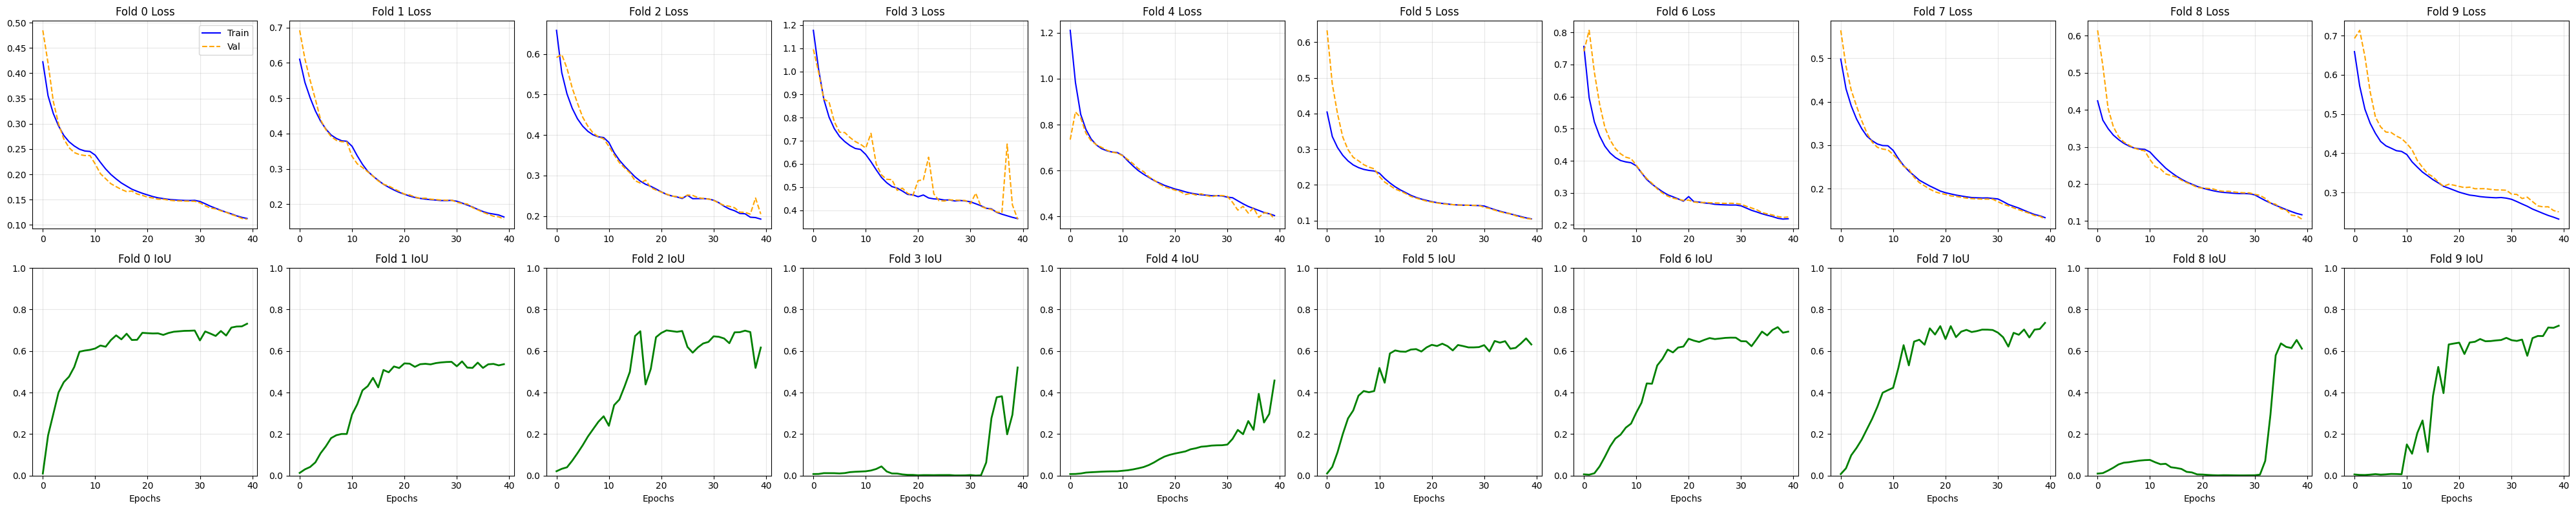

Models ready for Inference (1.2):
  -> fold_7_segmentation.onnx
  -> fold_5_segmentation.onnx
  -> fold_2_segmentation.onnx
  -> fold_3_segmentation.onnx
  -> fold_8_segmentation.onnx
  -> fold_6_segmentation.onnx
  -> fold_0_segmentation.onnx
  -> fold_9_segmentation.onnx
  -> fold_1_segmentation.onnx
  -> fold_4_segmentation.onnx


In [7]:
# --- CHUNK 7: VISUALIZATION REPORT ---
def plot_results(histories):
    folds = len(histories)
    # Create a 2-row grid: Top row = Loss, Bottom row = IoU
    fig, axes = plt.subplots(2, folds, figsize=(4 * folds, 8))
    
    # Handle single fold edge-case for plotting logic
    if folds == 1: axes = np.array([[axes[0]], [axes[1]]])
    if axes.ndim == 1: axes = axes.reshape(2, -1) # Ensure 2D array if 1 fold

    for fold, hist in enumerate(histories):
        # 1. Loss Plot (Top Row)
        ax_loss = axes[0, fold]
        ax_loss.plot(hist['train_loss'], label='Train', color='blue')
        ax_loss.plot(hist['val_loss'], label='Val', color='orange', linestyle='--')
        ax_loss.set_title(f"Fold {fold} Loss")
        ax_loss.grid(True, alpha=0.3)
        if fold == 0: ax_loss.legend()

        # 2. IoU Plot (Bottom Row)
        ax_iou = axes[1, fold]
        ax_iou.plot(hist['val_iou'], label='Val IoU', color='green', linewidth=2)
        ax_iou.set_title(f"Fold {fold} IoU")
        ax_iou.set_xlabel("Epochs")
        ax_iou.grid(True, alpha=0.3)
        ax_iou.set_ylim(0, 1.0)

    plt.tight_layout()
    plt.show()

print("📊 Generating Performance Report...")
plot_results(fold_histories)

print("Models ready for Inference (1.2):")
for f in CFG.WORK_DIR.glob("*.onnx"):
    print(f"  -> {f.name}")

In [8]:
!pip install -q onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00


🚀 Initializing Ensemble with 10 Grayscale models...
  [LOADED] fold_0_segmentation.onnx
  [LOADED] fold_1_segmentation.onnx
  [LOADED] fold_2_segmentation.onnx
  [LOADED] fold_3_segmentation.onnx
  [LOADED] fold_4_segmentation.onnx
  [LOADED] fold_5_segmentation.onnx
  [LOADED] fold_6_segmentation.onnx
  [LOADED] fold_7_segmentation.onnx
  [LOADED] fold_8_segmentation.onnx
  [LOADED] fold_9_segmentation.onnx
Running Ensemble Inference on 2 samples...


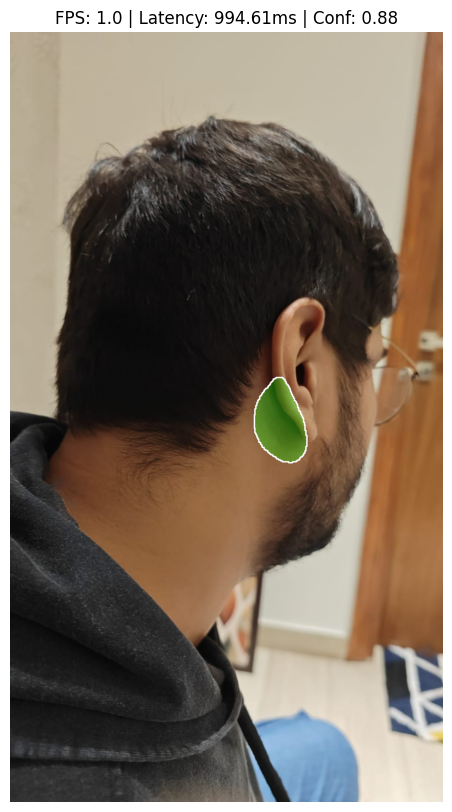

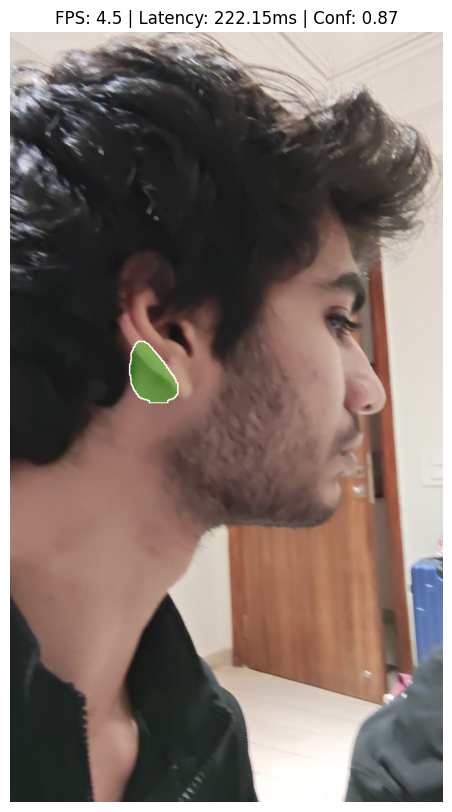

In [9]:
# --- FINAL CHUNK: ENSEMBLE INFERENCE & VISUALIZATION ---
import onnxruntime as ort

class PatchPredictor:
    def __init__(self, model_dir, yolo_model='yolo11n-seg.pt'):
        self.model_dir = Path(model_dir)
        self.img_size = 512
        self.sessions = []
        
        # 1. Initialize Ensemble (Load all 5 Folds)
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        onnx_files = sorted(list(self.model_dir.glob("fold_*_segmentation.onnx")))
        
        print(f"🚀 Initializing Ensemble with {len(onnx_files)} Grayscale models...")
        for m_path in onnx_files:
            try:
                session = ort.InferenceSession(str(m_path), providers=providers)
                self.sessions.append(session)
                print(f"  [LOADED] {m_path.name}")
            except Exception as e:
                print(f"  [FAILED] {m_path.name}: {e}")

        if not self.sessions:
            raise RuntimeError("No ONNX models found. Check training step.")

        self.input_name = self.sessions[0].get_inputs()[0].name
        self.yolo = YOLO(yolo_model)

    def preprocess(self, image_path):
        """Exact same pipeline: YOLO -> Black BG -> Gray -> Smart Crop"""
        img_bgr = cv2.imread(str(image_path))
        if img_bgr is None: raise ValueError(f"Image not found: {image_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # 1. Detect Person
        results = self.yolo(cv2.resize(img_rgb, (640, 640)), verbose=False)
        person_mask = np.zeros((h, w), dtype=np.uint8)
        if results[0].masks:
            idx = torch.argmax(results[0].boxes.xywh[:, 2] * results[0].boxes.xywh[:, 3])
            m = results[0].masks.data[idx].cpu().numpy()
            person_mask = (cv2.resize(m, (w, h)) > 0.5).astype(np.uint8)
        else:
             # Fallback: Center crop
            cv2.rectangle(person_mask, (w//4, h//4), (3*w//4, 3*h//4), 1, -1)

        # 2. Black Background & Grayscale
        isolated = np.where(np.stack((person_mask,) * 3, axis=-1) > 0, img_rgb, 0)
        gray_img = cv2.cvtColor(isolated, cv2.COLOR_RGB2GRAY)

        # 3. Smart Crop Logic
        y_head = np.argmax(np.any(person_mask, axis=1)) if np.any(person_mask) else 0
        roi_h = max(h // 3, 300) 
        dim = max(int(roi_h * 1.8), 300)
        center_x = int(np.dot(np.arange(w), np.sum(person_mask, axis=0)) / (np.sum(person_mask)+1e-6))

        half = dim // 2
        x1, y1 = center_x - half, y_head + (roi_h // 2) - half
        p_l, p_t = max(0, -x1), max(0, -y1)
        p_r, p_b = max(0, (x1 + dim) - w), max(0, (y1 + dim) - h)
        
        padded_gray = cv2.copyMakeBorder(gray_img, p_t, p_b, p_l, p_r, cv2.BORDER_CONSTANT, value=0)
        padded_rgb = cv2.copyMakeBorder(img_rgb, p_t, p_b, p_l, p_r, cv2.BORDER_CONSTANT, value=0)
        
        cx1, cy1 = x1 + p_l, y1 + p_t
        crop_gray = cv2.resize(padded_gray[cy1:cy1+dim, cx1:cx1+dim], (self.img_size, self.img_size))
        
        # 4. Normalize (Grayscale: Mean=0.5, Std=0.5)
        norm_img = crop_gray.astype(np.float32) / 255.0
        norm_img = (norm_img - 0.5) / 0.5 
        blob = np.expand_dims(np.expand_dims(norm_img, axis=0), axis=0) # [1, 1, 512, 512]
        
        meta = {'padded_rgb': padded_rgb, 'crop_coords': (cx1, cy1, cx1+dim, cy1+dim), 
                'orig_size': (h, w), 'pad_info': (p_t, p_l)}
        return blob.astype(np.float32), meta

    def predict_ensemble(self, input_tensor):
        """Averages the 5 folds"""
        start_time = time.perf_counter()
        ensemble_probs = []

        for session in self.sessions:
            outputs = session.run(None, {self.input_name: input_tensor})
            logits = outputs[0][0, 0, :, :]
            probs = 1 / (1 + np.exp(-logits)) 
            ensemble_probs.append(probs)

        final_probs = np.mean(ensemble_probs, axis=0)
        
        latency = (time.perf_counter() - start_time) * 1000
        fps = 1000 / latency if latency > 0 else 0
        return final_probs, latency, fps

    def apply_cleaning(self, mask):
        """Morphological Cleaning"""
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        return mask

    def visualize(self, image_path):
        try:
            input_tensor, meta = self.preprocess(image_path)
            probs, latency, fps = self.predict_ensemble(input_tensor)
            
            # Refine mask
            mask = (probs > 0.35).astype(np.uint8)
            mask = self.apply_cleaning(mask)
            
            # RECONSTRUCTION: Place prediction back onto original image
            padded_rgb = meta['padded_rgb']
            cx1, cy1, cx2, cy2 = meta['crop_coords']
            crop_h, crop_w = cy2 - cy1, cx2 - cx1
            
            real_mask = cv2.resize(mask, (crop_w, crop_h), interpolation=cv2.INTER_NEAREST)
            overlay = padded_rgb.copy()
            roi = overlay[cy1:cy2, cx1:cx2]
            
            green_mask = np.zeros_like(roi)
            green_mask[:] = [0, 255, 0]
            
            # Apply prediction overlay
            overlay[cy1:cy2, cx1:cx2] = np.where(real_mask[:, :, None] == 1, 
                                               cv2.addWeighted(roi, 0.7, green_mask, 0.3, 0), 
                                               roi)
            
            # Draw contours
            cnts, _ = cv2.findContours(real_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay[cy1:cy2, cx1:cx2], cnts, -1, (255, 255, 255), 2)
            
            # Crop back to exact original dimensions
            pt, pl = meta['pad_info']
            h, w = meta['orig_size']
            final_view = overlay[pt:pt+h, pl:pl+w]

            plt.figure(figsize=(10, 10))
            plt.imshow(final_view)
            plt.title(f"FPS: {fps:.1f} | Latency: {latency:.2f}ms | Conf: {np.max(probs):.2f}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Skipped {image_path.name}: {e}")

# --- EXECUTION ---
if __name__ == "__main__":
    TEST_DIR = Path("/kaggle/input/sample-3") # Update if your path is different
    
    predictor = PatchPredictor(CFG.WORK_DIR) # Uses models from current training
    test_imgs = sorted(list(TEST_DIR.glob("*.jpg")) + list(TEST_DIR.glob("*.png")))
    
    if test_imgs:
        print(f"Running Ensemble Inference on {len(test_imgs)} samples...")
        for img_path in test_imgs:
            predictor.visualize(img_path)
    else:
        print("No images found in test folder.")